In [ ]:
import pandas as pd
from google.colab import files

# Upload files
uploaded = files.upload()

for filename in uploaded.keys():
  print(f"Uploaded file: {filename}")


Saving Mumbai_2008_B3.TIF to Mumbai_2008_B3.TIF
Saving Mumbai_2008_B4.TIF to Mumbai_2008_B4.TIF
Saving Mumbai_2008_B5.TIF to Mumbai_2008_B5.TIF
Saving Mumbai_2009_B3.TIF to Mumbai_2009_B3.TIF
Saving Mumbai_2009_B4.TIF to Mumbai_2009_B4.TIF
Saving Mumbai_2009_B5.TIF to Mumbai_2009_B5.TIF
Saving Mumbai_2010_B3.TIF to Mumbai_2010_B3.TIF
Saving Mumbai_2010_B4.TIF to Mumbai_2010_B4.TIF
Saving Mumbai_2010_B5.TIF to Mumbai_2010_B5.TIF
Saving Mumbai_2011_B3.TIF to Mumbai_2011_B3.TIF
Saving Mumbai_2011_B4.TIF to Mumbai_2011_B4.TIF
Saving Mumbai_2011_B5.TIF to Mumbai_2011_B5.TIF
Saving Mumbai_2012_B3.TIF to Mumbai_2012_B3.TIF
Saving Mumbai_2012_B4.TIF to Mumbai_2012_B4.TIF
Saving Mumbai_2012_B5.TIF to Mumbai_2012_B5.TIF
Saving Mumbai_2013_B3.TIF to Mumbai_2013_B3.TIF
Saving Mumbai_2013_B4.TIF to Mumbai_2013_B4.TIF
Saving Mumbai_2013_B5.TIF to Mumbai_2013_B5.TIF
Saving Mumbai_2014_B3.TIF to Mumbai_2014_B3.TIF
Saving Mumbai_2014_B4.TIF to Mumbai_2014_B4.TIF
Saving Mumbai_2014_B5.TIF to Mumbai_2014

In [ ]:
import rasterio

# Check the metadata for the first file
file_path = '/content/Mumbai_2008_B3.TIF'
with rasterio.open(file_path) as src:
    print("Metadata for Mumbai_2008_B3.TIF:")
    print(f"CRS: {src.crs}")
    print(f"Transform: {src.transform}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Bounds: {src.bounds}")



Metadata for Mumbai_2008_B3.TIF:
CRS: EPSG:32643
Transform: | 30.00, 0.00, 97485.00|
| 0.00,-30.00, 2185215.00|
| 0.00, 0.00, 1.00|
Width: 7921
Height: 7061
Bounds: BoundingBox(left=97485.0, bottom=1973385.0, right=335115.0, top=2185215.0)


In [ ]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import numpy as np

def resample_image(image, src_profile, target_profile):
    try:
        # Use explicit bounds to improve resampling accuracy
        transform, width, height = calculate_default_transform(
            src_profile['crs'], target_profile['crs'],
            src_profile['width'], src_profile['height'],
            left=src_profile['transform'][2],
            bottom=src_profile['transform'][5] + src_profile['height'] * src_profile['transform'][4],
            right=src_profile['transform'][2] + src_profile['width'] * src_profile['transform'][0],
            top=src_profile['transform'][5]
        )

        # Update the target profile
        target_profile.update({
            'transform': transform,
            'width': width,
            'height': height
        })

        resampled_image = np.empty(shape=(height, width), dtype=np.float32)

        reproject(
            source=image,
            destination=resampled_image,
            src_transform=src_profile['transform'],
            src_crs=src_profile['crs'],
            dst_transform=transform,
            dst_crs=target_profile['crs'],
            resampling=Resampling.bilinear
        )

        return resampled_image
    except Exception as e:
        print(f"Error in resampling: {e}")
        return None


In [ ]:
!pip install rasterio numpy matplotlib


In [ ]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def load_band(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        profile = src.profile

        # If there's an issue with the transform, provide a default
        if not src.transform or src.transform.is_identity:
            print(f"Warning: Using default transform for {file_path}")
            profile['transform'] = rasterio.transform.from_origin(
                west=src.bounds.left,
                north=src.bounds.top,
                xsize=(src.bounds.right - src.bounds.left) / src.width,
                ysize=(src.bounds.top - src.bounds.bottom) / src.height
            )

        # Default to WGS84 if CRS is missing
        if not src.crs:
            print(f"Warning: Using default CRS for {file_path}")
            profile['crs'] = 'EPSG:4326'

        return data, profile

def resample_image(image, src_profile, target_profile):
    try:
        transform, width, height = calculate_default_transform(
            src_profile['crs'], target_profile['crs'],
            src_profile['width'], src_profile['height'],
            left=src_profile['transform'][2],
            bottom=src_profile['transform'][5] + src_profile['height'] * src_profile['transform'][4],
            right=src_profile['transform'][2] + src_profile['width'] * src_profile['transform'][0],
            top=src_profile['transform'][5]
        )

        target_profile.update({
            'transform': transform,
            'width': width,
            'height': height
        })

        resampled_image = np.empty(shape=(height, width), dtype=np.float32)

        reproject(
            source=image,
            destination=resampled_image,
            src_transform=src_profile['transform'],
            src_crs=src_profile['crs'],
            dst_transform=transform,
            dst_crs=target_profile['crs'],
            resampling=Resampling.bilinear
        )

        return resampled_image
    except Exception as e:
        print(f"Error in resampling: {e}")
        return None


In [ ]:
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014]
urban_areas = {}

# Load images and calculate NDBI
for year in years:
    print(f"Processing year: {year}")

    # Load the bands
    b3, profile3 = load_band(f'/content/Mumbai_{year}_B3.TIF')
    b4, profile4 = load_band(f'/content/Mumbai_{year}_B4.TIF')
    b5, profile5 = load_band(f'/content/Mumbai_{year}_B5.TIF')

    # Define a target profile using B3 as a reference
    target_profile = profile3

    # Resample all bands to the same resolution and transform
    b3_resampled = resample_image(b3, profile3, target_profile)
    b4_resampled = resample_image(b4, profile4, target_profile)
    b5_resampled = resample_image(b5, profile5, target_profile)

    if b3_resampled is None or b4_resampled is None or b5_resampled is None:
        print(f"Error processing year {year}: Resampling failed for one or more bands")
        continue

    # Calculate NDBI = (B5 - B4) / (B5 + B4)
    ndbi = (b5_resampled - b4_resampled) / (b5_resampled + b4_resampled)

    # Define a threshold to classify urban areas (you might need to adjust this)
    threshold = 0.2
    urban_area = ndbi > threshold

    urban_areas[year] = urban_area

    print(f"Finished processing year: {year}")

# Detect changes over the years
urban_changes = []
for i in range(len(years) - 1):
    year1, year2 = years[i], years[i + 1]
    change = (urban_areas[year2].astype(int) - urban_areas[year1].astype(int)) > 0
    urban_changes.append((year1, year2, change))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=len(urban_changes), figsize=(20, 10))
for idx, (year1, year2, change) in enumerate(urban_changes):
    axs[idx].imshow(change, cmap='gray')
    axs[idx].set_title(f'Urban Change {year1}-{year2}')
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


Processing year: 2008
Finished processing year: 2008
Processing year: 2009
Finished processing year: 2009
Processing year: 2010
Finished processing year: 2010
Processing year: 2011
Finished processing year: 2011
Processing year: 2012
Finished processing year: 2012
Processing year: 2013
Finished processing year: 2013
Processing year: 2014
Finished processing year: 2014


ValueError: operands could not be broadcast together with shapes (7051,8001) (7061,7921) 

In [ ]:
# Determine the minimum shape for standardization
min_shape = (min(profile['height'] for profile in [profile3, profile4, profile5]),
             min(profile['width'] for profile in [profile3, profile4, profile5]))


In [ ]:
def resample_image_to_shape(image, src_profile, target_shape):
    target_height, target_width = target_shape
    target_transform = rasterio.transform.from_bounds(
        src_profile['transform'][2],
        src_profile['transform'][5] + src_profile['transform'][4] * src_profile['height'],
        src_profile['transform'][2] + src_profile['transform'][0] * src_profile['width'],
        src_profile['transform'][5],
        target_width,
        target_height
    )

    target_profile = src_profile.copy()
    target_profile.update({
        'height': target_height,
        'width': target_width,
        'transform': target_transform
    })

    resampled_image = np.empty(shape=(target_height, target_width), dtype=np.float32)

    reproject(
        source=image,
        destination=resampled_image,
        src_transform=src_profile['transform'],
        src_crs=src_profile['crs'],
        dst_transform=target_transform,
        dst_crs=src_profile['crs'],
        resampling=Resampling.bilinear
    )

    return resampled_image


In [ ]:
# Initialize urban_areas dictionary
urban_areas = {}

# Process each year
for year in years:
    print(f"Processing year: {year}")

    # Load the bands
    b3, profile3 = load_band(f'/content/Mumbai_{year}_B3.TIF')
    b4, profile4 = load_band(f'/content/Mumbai_{year}_B4.TIF')
    b5, profile5 = load_band(f'/content/Mumbai_{year}_B5.TIF')

    # Resample all bands to the minimum shape
    b3_resampled = resample_image_to_shape(b3, profile3, min_shape)
    b4_resampled = resample_image_to_shape(b4, profile4, min_shape)
    b5_resampled = resample_image_to_shape(b5, profile5, min_shape)

    # Check for resampling errors
    if b3_resampled is None or b4_resampled is None or b5_resampled is None:
        print(f"Error processing year {year}: Resampling failed for one or more bands")
        continue

    # Calculate NDBI = (B5 - B4) / (B5 + B4)
    ndbi = (b5_resampled - b4_resampled) / (b5_resampled + b4_resampled)

    # Define a threshold to classify urban areas (you might need to adjust this)
    threshold = 0.2
    urban_area = ndbi > threshold

    urban_areas[year] = urban_area

    print(f"Finished processing year: {year}")


Processing year: 2008
Finished processing year: 2008
Processing year: 2009
Finished processing year: 2009
Processing year: 2010
Finished processing year: 2010
Processing year: 2011
Finished processing year: 2011
Processing year: 2012
Finished processing year: 2012
Processing year: 2013
Finished processing year: 2013
Processing year: 2014
Finished processing year: 2014


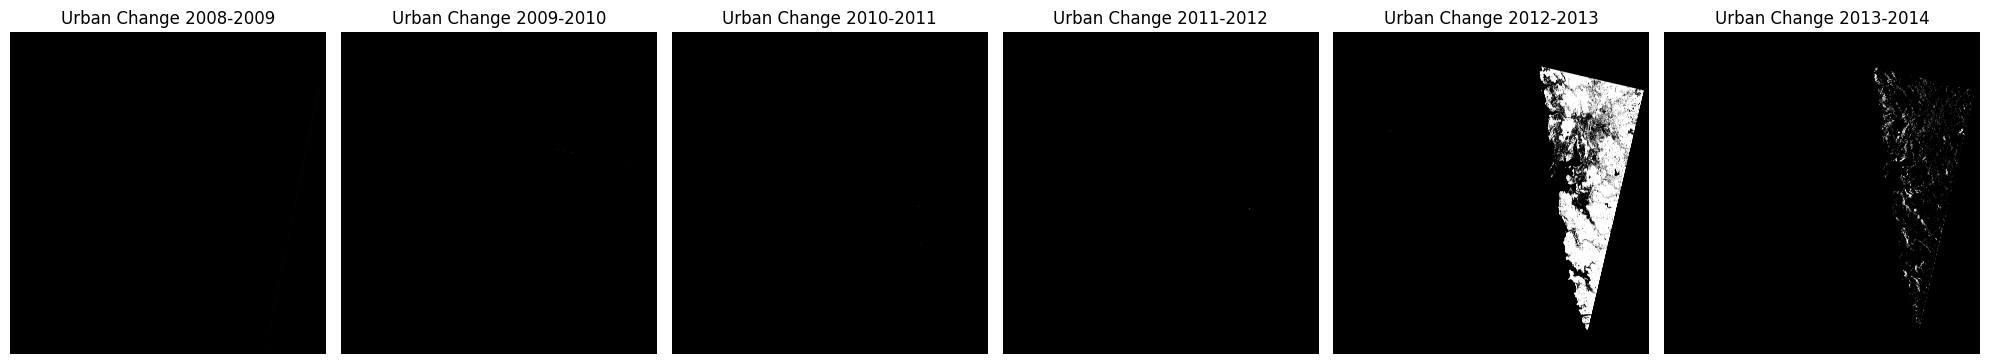

In [ ]:
# Detect changes over the years
urban_changes = []
for i in range(len(years) - 1):
    year1, year2 = years[i], years[i + 1]
    change = (urban_areas[year2].astype(int) - urban_areas[year1].astype(int)) > 0
    urban_changes.append((year1, year2, change))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=len(urban_changes), figsize=(20, 10))
for idx, (year1, year2, change) in enumerate(urban_changes):
    axs[idx].imshow(change, cmap='gray')
    axs[idx].set_title(f'Urban Change {year1}-{year2}')
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def calculate_urban_statistics(urban_area):
    # Count the number of urban pixels
    urban_pixel_count = np.sum(urban_area)

    # Calculate the area based on pixel size (assuming a specific pixel size in meters)
    pixel_size_m2 = abs(target_profile['transform'][0]) * abs(target_profile['transform'][4])
    urban_area_m2 = urban_pixel_count * pixel_size_m2

    return urban_pixel_count, urban_area_m2

# Calculate and print statistics for each year
urban_statistics = {}
for year in years:
    urban_pixel_count, urban_area_m2 = calculate_urban_statistics(urban_areas[year])
    urban_statistics[year] = {
        'urban_pixel_count': urban_pixel_count,
        'urban_area_m2': urban_area_m2
    }

print("Urban Statistics (Pixel Count and Area in m²):")
for year, stats in urban_statistics.items():
    print(f"Year {year}: {stats['urban_pixel_count']} pixels, {stats['urban_area_m2']:.2f} m²")


Urban Statistics (Pixel Count and Area in m²):
Year 2008: 2236 pixels, 2012400.00 m²
Year 2009: 2104 pixels, 1893600.00 m²
Year 2010: 463 pixels, 416700.00 m²
Year 2011: 221 pixels, 198900.00 m²
Year 2012: 233 pixels, 209700.00 m²
Year 2013: 5896491 pixels, 5306841900.00 m²
Year 2014: 2723248 pixels, 2450923200.00 m²


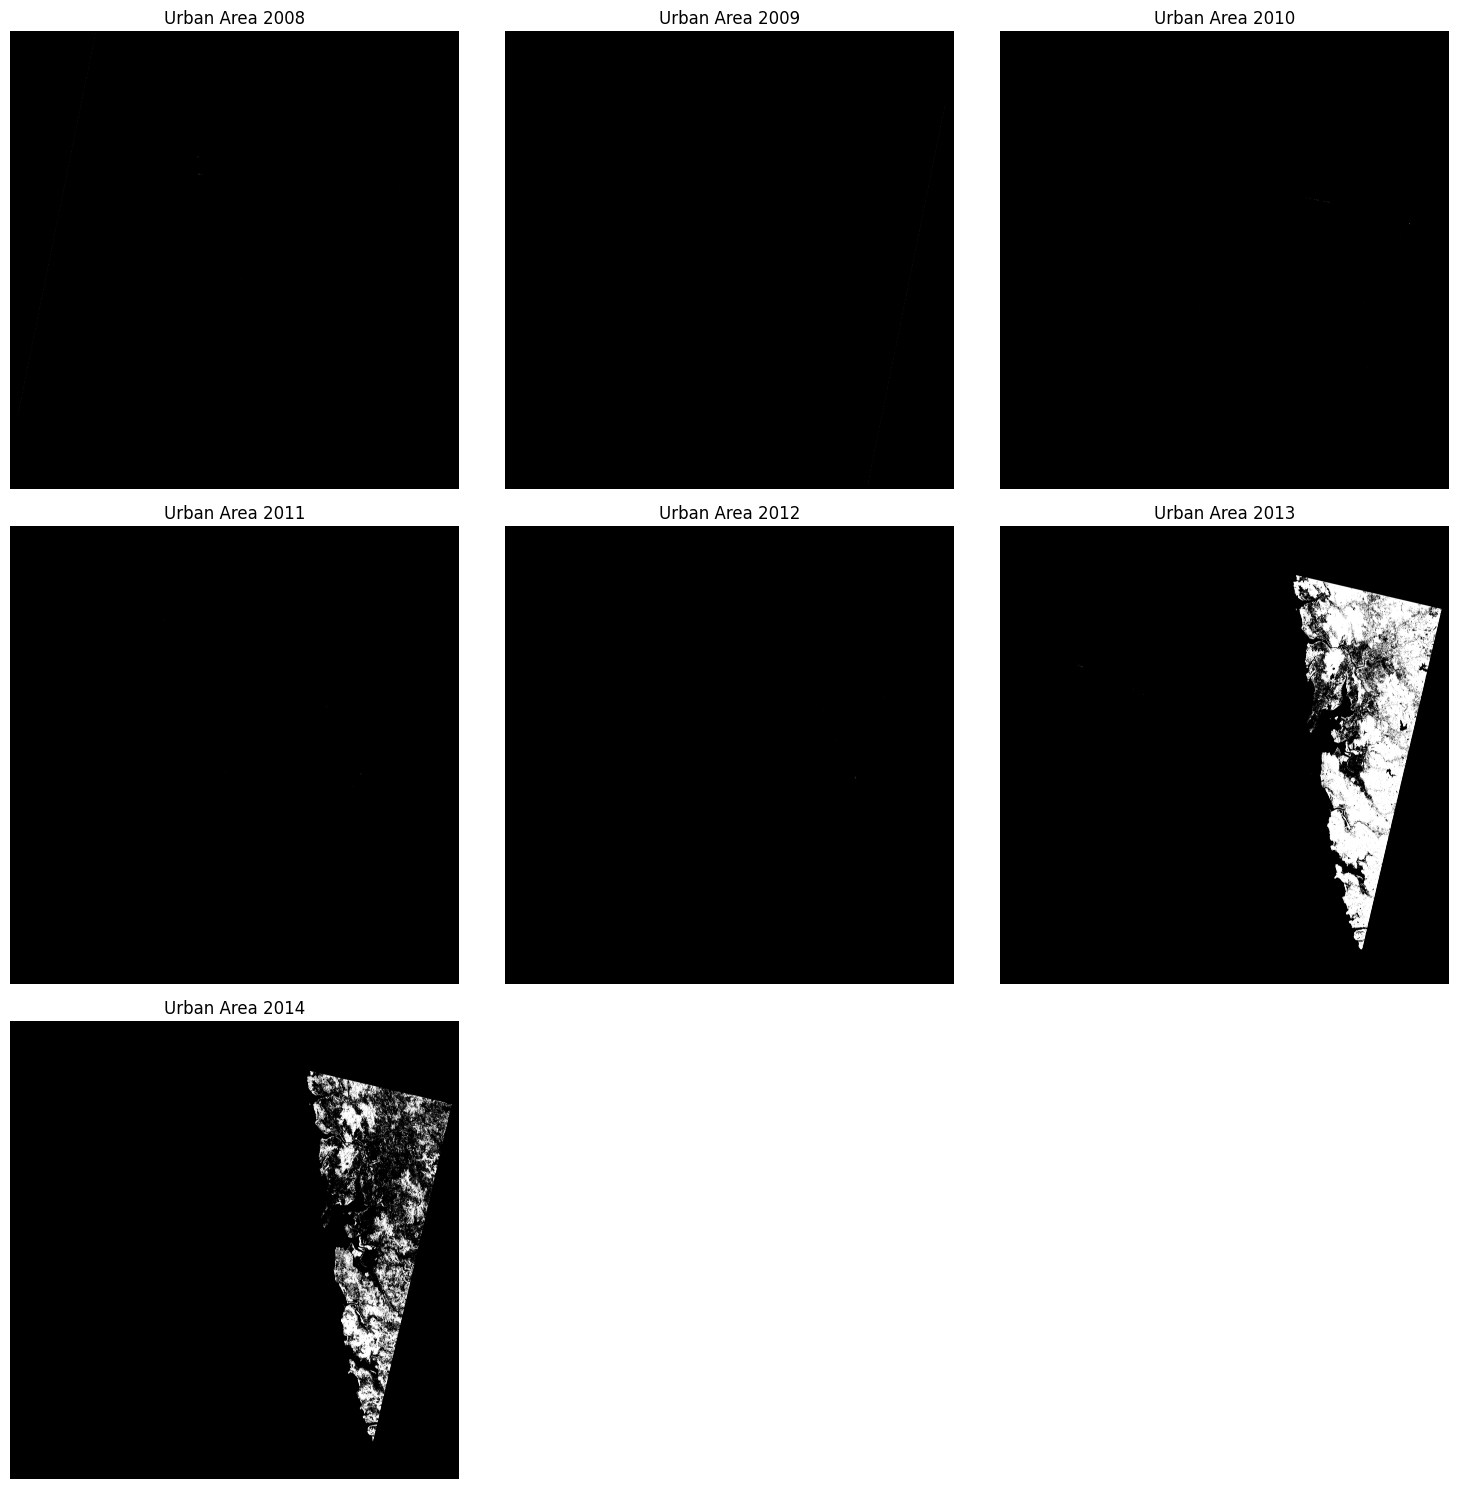

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of years
num_years = len(years)

# Calculate the number of rows and columns for subplots
ncols = 3  # Number of columns for subplots (adjust as needed)
nrows = (num_years + ncols - 1) // ncols  # Number of rows to fit all plots

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

# Plot each year's urban area
for idx, year in enumerate(years):
    ax = axs[idx]
    ax.imshow(urban_areas[year], cmap='gray')
    ax.set_title(f'Urban Area {year}')
    ax.axis('off')

# Hide any unused subplots
for idx in range(len(years), len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


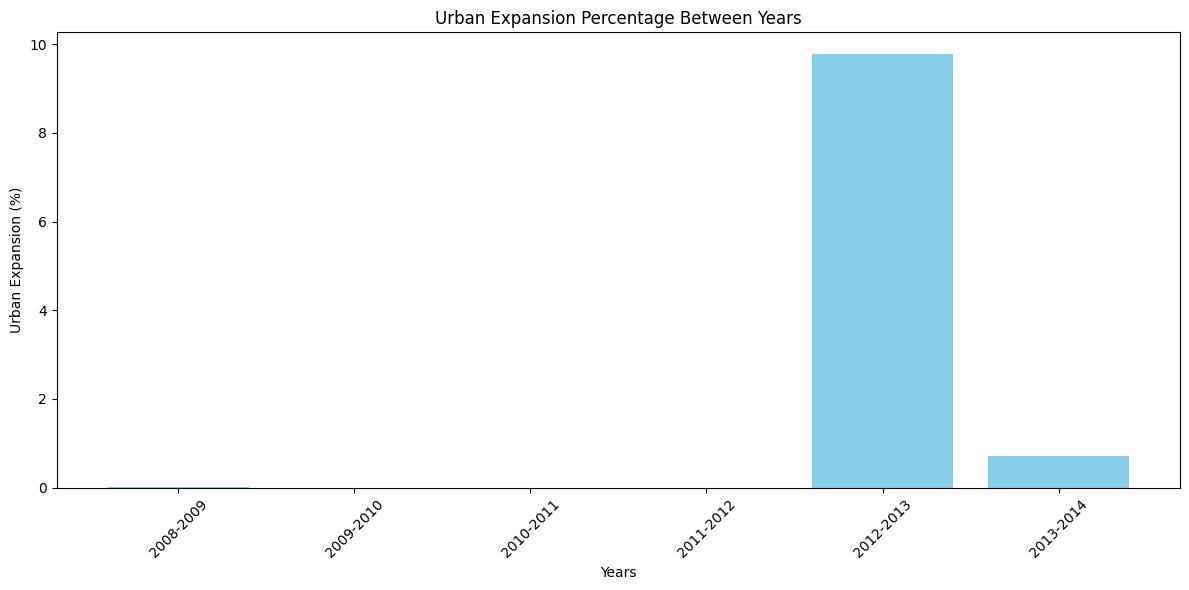

In [ ]:
# Check if urban_changes is populated
if not urban_changes:
    print("No urban changes detected.")
else:
    # Calculate percentages of urban expansion
    change_percentages = []
    years_pairs = []

    for (year1, year2, change) in urban_changes:
        # Calculate the percentage of change
        urban_area_year1 = urban_areas[year1]
        urban_area_year2 = urban_areas[year2]

        total_pixels = urban_area_year1.size
        change_pixels = np.sum(change)
        change_percentage = (change_pixels / total_pixels) * 100

        change_percentages.append(change_percentage)
        years_pairs.append(f"{year1}-{year2}")

    # Plot the change percentages
    plt.figure(figsize=(12, 6))
    plt.bar(years_pairs, change_percentages, color='skyblue')
    plt.xlabel('Years')
    plt.ylabel('Urban Expansion (%)')
    plt.title('Urban Expansion Percentage Between Years')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


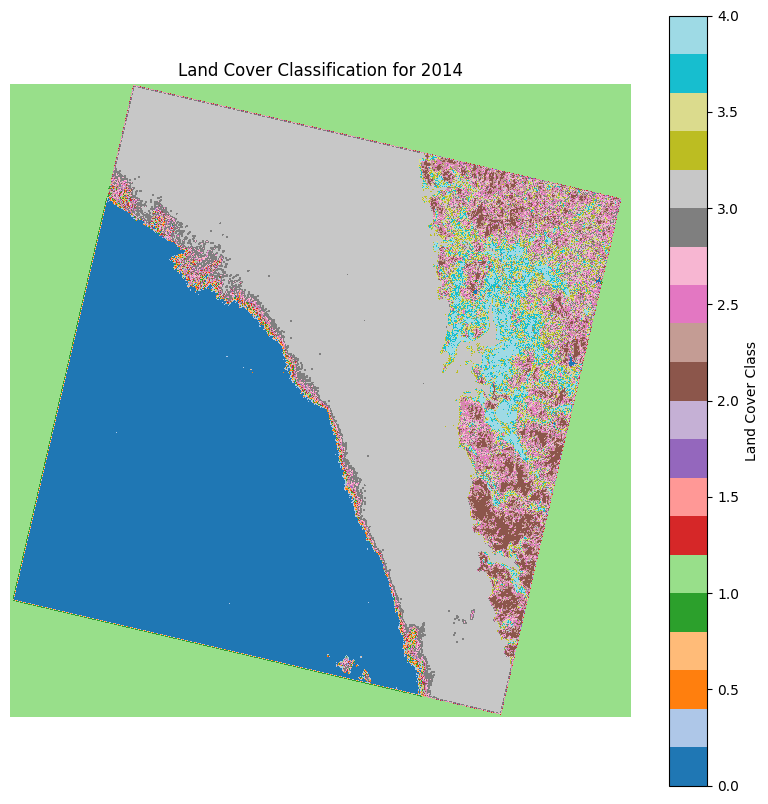

In [ ]:
import numpy as np
import rasterio
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def stack_bands(bands):
    """ Stack multiple bands into a single 3D array. """
    return np.stack(bands, axis=-1)

def classify_land_cover(image, n_clusters=5):
    """ Perform K-means classification on the stacked bands. """
    # Flatten the image to 2D for clustering
    rows, cols, bands = image.shape
    flat_image = image.reshape(-1, bands)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flat_image)
    classified_image = kmeans.labels_.reshape(rows, cols)

    return classified_image

# Load and stack bands
def load_bands(year):
    band3, _ = load_band(f'/content/Mumbai_{year}_B3.TIF')
    band4, _ = load_band(f'/content/Mumbai_{year}_B4.TIF')
    band5, _ = load_band(f'/content/Mumbai_{year}_B5.TIF')
    bands = stack_bands([band3, band4, band5])
    return bands

# Perform classification for a specific year
year = '2014'  # Example year
bands = load_bands(year)
classified_image = classify_land_cover(bands, n_clusters=5)

# Visualize classification results
plt.figure(figsize=(10, 10))
plt.imshow(classified_image, cmap='tab20')
plt.title(f'Land Cover Classification for {year}')
plt.colorbar(label='Land Cover Class')
plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


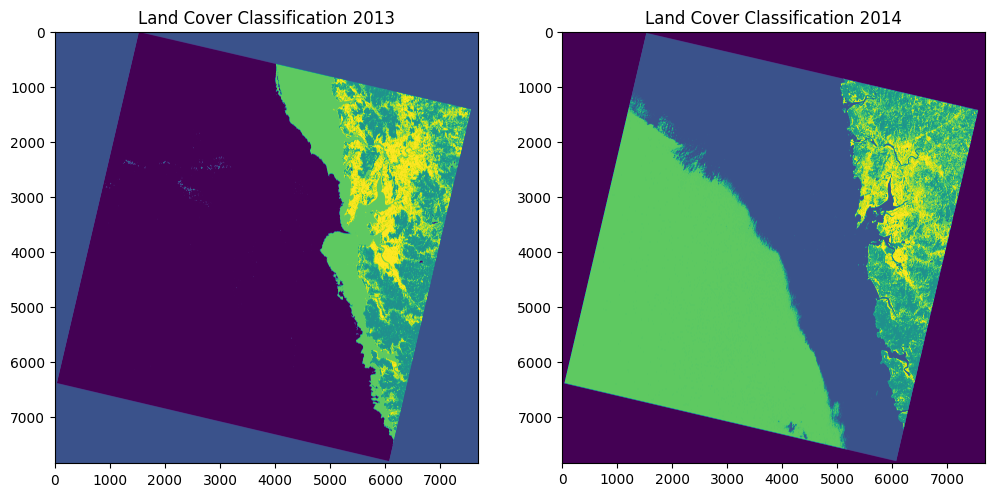

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a function to load bands
def load_bands(year):
    bands = {}
    for band_name in ['B3', 'B4', 'B5']:
        with rasterio.open(f'Mumbai_{year}_{band_name}.TIF') as src:
            bands[band_name] = src.read(1)
    return bands

# Define a function to stack and classify bands
def classify_land_cover(bands, n_clusters=5):
    # Stack bands into a 3D array (bands, height, width)
    stacked_bands = np.stack([bands['B3'], bands['B4'], bands['B5']], axis=-1)

    # Reshape for clustering
    num_rows, num_cols, num_bands = stacked_bands.shape
    reshaped_bands = stacked_bands.reshape(-1, num_bands)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reshaped_bands)

    # Reshape labels back to image shape
    classified_image = labels.reshape(num_rows, num_cols)
    return classified_image

# Load and classify bands for two years
year1 = '2013'
year2 = '2014'
bands1 = load_bands(year1)
bands2 = load_bands(year2)
classified_image1 = classify_land_cover(bands1, n_clusters=5)
classified_image2 = classify_land_cover(bands2, n_clusters=5)

# Visualize the classified images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(classified_image1, cmap='viridis')
axs[0].set_title(f'Land Cover Classification {year1}')
axs[1].imshow(classified_image2, cmap='viridis')
axs[1].set_title(f'Land Cover Classification {year2}')
plt.show()


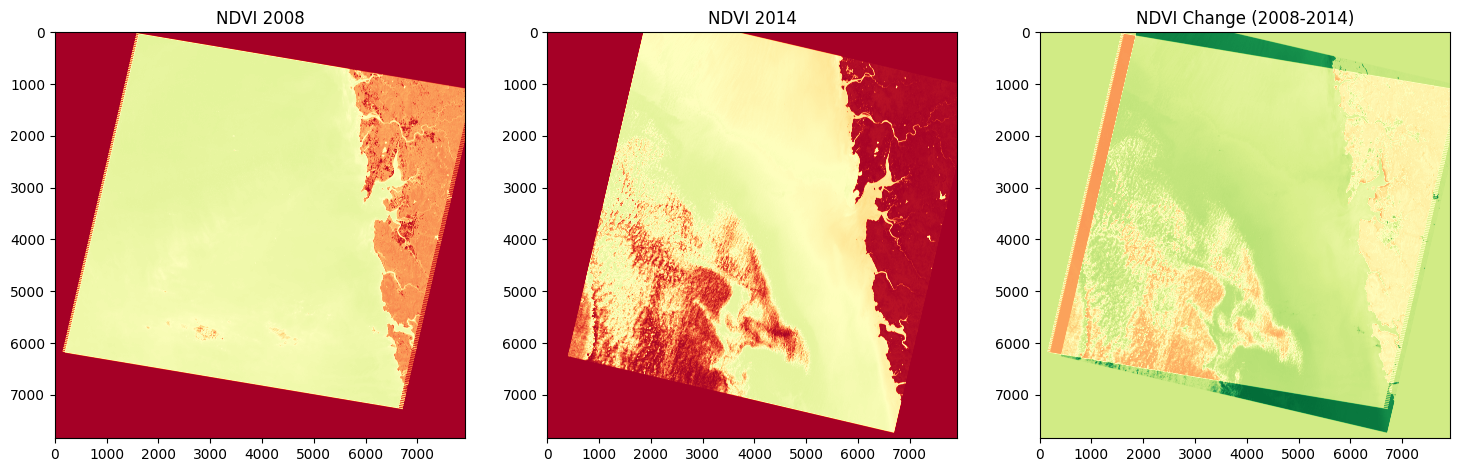

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Function to calculate NDVI
def calculate_ndvi(red_band, nir_band):
    # Add a small constant to avoid division by zero
    return (nir_band - red_band) / (nir_band + red_band + 1e-10)

# Load bands and calculate NDVI
def load_bands_and_calculate_ndvi(year):
    bands = {}
    for band_name in ['B3', 'B4', 'B5']:
        with rasterio.open(f'Mumbai_{year}_{band_name}.TIF') as src:
            bands[band_name] = src.read(1)
            profile = src.profile

    ndvi = calculate_ndvi(bands['B4'], bands['B5'])
    return ndvi, profile

# Resample images to match dimensions
def resample_image(src_image, src_profile, target_profile):
    dst_array = np.empty((target_profile['height'], target_profile['width']), dtype=np.float32)
    reproject(
        source=src_image,
        destination=dst_array,
        src_transform=src_profile['transform'],
        src_crs=src_profile['crs'],
        dst_transform=target_profile['transform'],
        dst_crs=target_profile['crs'],
        resampling=Resampling.nearest
    )
    return dst_array

# Change detection for NDVI
def detect_vegetation_change(ndvi1, ndvi2):
    # Ensure both NDVI arrays have the same shape
    if ndvi1.shape != ndvi2.shape:
        raise ValueError("NDVI images have different shapes.")
    return ndvi2 - ndvi1

# Visualization
def visualize(ndvi1, ndvi2, change):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(ndvi1, cmap='RdYlGn')
    axs[0].set_title('NDVI 2008')
    axs[1].imshow(ndvi2, cmap='RdYlGn')
    axs[1].set_title('NDVI 2014')
    axs[2].imshow(change, cmap='RdYlGn')
    axs[2].set_title('NDVI Change (2008-2014)')
    plt.show()

# Load NDVI for two years
year1 = '2008'
year2 = '2014'
ndvi1, profile1 = load_bands_and_calculate_ndvi(year1)
ndvi2, profile2 = load_bands_and_calculate_ndvi(year2)

# Define target profile with the dimensions of the larger image
target_profile = {
    'crs': 'EPSG:32643',  # Adjust if needed
    'transform': None,  # This will be set dynamically
    'width': max(ndvi1.shape[1], ndvi2.shape[1]),
    'height': max(ndvi1.shape[0], ndvi2.shape[0]),
    'count': 1,
    'dtype': 'float32'
}

# Get bounds from one of the profiles
def get_bounds(profile):
    return rasterio.transform.xy(profile['transform'], 0, 0) + rasterio.transform.xy(profile['transform'], profile['height'], profile['width'])

bounds1 = get_bounds(profile1)
bounds2 = get_bounds(profile2)
bounds = (min(bounds1[0], bounds2[0]), min(bounds1[1], bounds2[1]),
          max(bounds1[2], bounds2[2]), max(bounds1[3], bounds2[3]))

# Calculate default transform for target profile
transform, width, height = calculate_default_transform(
    profile1['crs'],
    'EPSG:32643',
    target_profile['width'],
    target_profile['height'],
    *bounds
)
target_profile['transform'] = transform

# Resample NDVI images
ndvi1_resampled = resample_image(ndvi1, profile1, target_profile)
ndvi2_resampled = resample_image(ndvi2, profile2, target_profile)

# Detect vegetation change
change = detect_vegetation_change(ndvi1_resampled, ndvi2_resampled)

# Visualize results
visualize(ndvi1_resampled, ndvi2_resampled, change)


In [ ]:
import numpy as np

# Function to calculate statistics
def calculate_statistics(ndvi1, ndvi2, change):
    stats = {}

    # NDVI statistics
    stats['mean_ndvi1'] = np.nanmean(ndvi1)
    stats['std_ndvi1'] = np.nanstd(ndvi1)
    stats['mean_ndvi2'] = np.nanmean(ndvi2)
    stats['std_ndvi2'] = np.nanstd(ndvi2)

    # NDVI change statistics
    stats['mean_change'] = np.nanmean(change)
    stats['std_change'] = np.nanstd(change)

    # Area of significant change
    significant_change = np.abs(change) > 0.1  # Adjust the threshold as needed
    stats['area_significant_change'] = np.sum(significant_change) * (target_profile['transform'][0] ** 2)  # Area in square meters

    return stats

# Calculate statistics for NDVI and changes
stats = calculate_statistics(ndvi1_resampled, ndvi2_resampled, change)

# Print statistics
print("NDVI 2008 Statistics:")
print(f"Mean NDVI: {stats['mean_ndvi1']:.4f}")
print(f"Standard Deviation NDVI: {stats['std_ndvi1']:.4f}")

print("\nNDVI 2014 Statistics:")
print(f"Mean NDVI: {stats['mean_ndvi2']:.4f}")
print(f"Standard Deviation NDVI: {stats['std_ndvi2']:.4f}")

print("\nNDVI Change Statistics:")
print(f"Mean Change: {stats['mean_change']:.4f}")
print(f"Standard Deviation Change: {stats['std_change']:.4f}")

print("\nArea of Significant Change (m²):")
print(f"Area of Significant Change: {stats['area_significant_change']:.2f}")


NDVI 2008 Statistics:
Mean NDVI: 2.4782
Standard Deviation NDVI: 1.8831

NDVI 2014 Statistics:
Mean NDVI: 2.0648
Standard Deviation NDVI: 2.0783

NDVI Change Statistics:
Mean Change: -0.4134
Standard Deviation Change: 1.6093

Area of Significant Change (m²):
Area of Significant Change: 33816414940.23
